<a href="https://colab.research.google.com/github/kskrajny/MSI-Segmentation/blob/master/sztuczne.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install pyspark
!pip install pandas

# Import libraries
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
import os
import time

start_time = time.time()

# Set up Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Magisterka") \
    .config("spark.driver.memory", "50g") \
    .config("spark.driver.maxResultSize", "0") \
    .getOrCreate()

In [ ]:
from datetime import datetime
import pytz

poland_tz = pytz.timezone('Europe/Warsaw')
current_time_poland = datetime.now(poland_tz)
formatted_date = current_time_poland.strftime('%d-%m-%Y-%H-%M')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#dataset = "pecherz"
#dataset = "watroba"
dataset = "sztuczne_dane"

if dataset == "sztuczne_dane":
  input_dim = 59
  last_dim = 32
  kernel_sizes = [7, 3]
  hidden_dims = [1, 2, 4]
  strides = [2, 2]

convolve = "False"

parquet_dir = "/content/drive/My Drive/MSI-Segmentation/dane/" + dataset + "/parquet_convolve_" + convolve
output_folder = "/content/drive/My Drive/MSI-Segmentation/results/" + dataset + f"_{formatted_date}_conv_" + convolve

class HParams:
    def __init__(self, input_dim, kernel_sizes, last_dim, hidden_dims, strides, batch_size=64, lr=1e-3, epochs=1000, batch_step=9000, patience=30):
        self.input_dim = input_dim
        self.kernel_sizes = kernel_sizes
        self.last_dim = last_dim
        self.hidden_dims = hidden_dims
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.batch_size = batch_size
        self.lr = lr
        self.epochs = epochs
        self.batch_step = batch_step
        self.patience = patience
        self.strides = strides

hparams_CLR = HParams(input_dim, kernel_sizes, last_dim, hidden_dims, strides)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from pyspark.sql import SparkSession
import numpy as np


class ParquetDataset(Dataset):
    def __init__(self, parquet_dir, global_std, global_mean):
        self.spark = SparkSession.builder.getOrCreate()
        self.df = self.spark.read.parquet(parquet_dir).sort('pos')
        self.data = self.df.collect()
        self.global_std = 1
        self.global_mean = 0

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        features = torch.Tensor(sample['features'].toArray())
        normalized_features = (features - self.global_mean) / self.global_std
        return {'features': normalized_features, 'pos': sample['pos']}

def collate_fn(batch):
    features = [item['features'] for item in batch]
    pos = [item['pos'] for item in batch]
    return {'features': torch.stack(features), 'pos': pos}


def calculate_global_mean_std(parquet_dir):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.parquet(parquet_dir)
    features_rdd = df.select('features').rdd.map(lambda row: np.array(row['features'].toArray()))
    all_features = np.vstack(features_rdd.collect())
    global_std = all_features.std()
    global_mean = all_features.mean()
    return global_std, global_mean

def create_dataloader(parquet_dir, batch_size, shuffle):
    global_std, global_mean = calculate_global_mean_std(parquet_dir)
    dataset = ParquetDataset(parquet_dir, global_std, global_mean)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn, drop_last=True)

'''

import torch
from torch.utils.data import Dataset, DataLoader
from pyspark.sql import SparkSession
import numpy as np

class ParquetDataset(Dataset):
    def __init__(self, parquet_dir, feature_stds, feature_means):
        self.spark = SparkSession.builder.getOrCreate()
        self.df = self.spark.read.parquet(parquet_dir).sort('pos')
        self.data = self.df.collect()
        self.feature_stds = torch.Tensor(feature_stds)
        self.feature_means = torch.Tensor(feature_means)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        features = torch.Tensor(sample['features'].toArray())
        normalized_features = (features - self.feature_means) / self.feature_stds
        return {'features': normalized_features, 'pos': sample['pos']}

def collate_fn(batch):
    features = [item['features'] for item in batch]
    pos = [item['pos'] for item in batch]
    return {'features': torch.stack(features), 'pos': pos}

def calculate_feature_stds(parquet_dir):
    spark = SparkSession.builder.getOrCreate()
    df = spark.read.parquet(parquet_dir)
    features_rdd = df.select('features').rdd.map(lambda row: np.array(row['features'].toArray()))
    all_features = np.vstack(features_rdd.collect())
    feature_stds = all_features.std(axis=0)
    feature_means = all_features.mean(axis=0)
    return feature_stds, feature_means

def create_dataloader(parquet_dir, batch_size, shuffle):
    feature_stds, feature_means = calculate_feature_stds(parquet_dir)
    dataset = ParquetDataset(parquet_dir, feature_stds, feature_means)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=collate_fn)
'''

"\n\nimport torch\nfrom torch.utils.data import Dataset, DataLoader\nfrom pyspark.sql import SparkSession\nimport numpy as np\n\nclass ParquetDataset(Dataset):\n    def __init__(self, parquet_dir, feature_stds, feature_means):\n        self.spark = SparkSession.builder.getOrCreate()\n        self.df = self.spark.read.parquet(parquet_dir).sort('pos')\n        self.data = self.df.collect()\n        self.feature_stds = torch.Tensor(feature_stds)\n        self.feature_means = torch.Tensor(feature_means)\n\n    def __len__(self):\n        return len(self.data)\n\n    def __getitem__(self, idx):\n        sample = self.data[idx]\n        features = torch.Tensor(sample['features'].toArray())\n        normalized_features = (features - self.feature_means) / self.feature_stds\n        return {'features': normalized_features, 'pos': sample['pos']}\n\ndef collate_fn(batch):\n    features = [item['features'] for item in batch]\n    pos = [item['pos'] for item in batch]\n    return {'features': torch

In [ ]:
import json


def noise(vec):
    noise = np.random.normal(1, .1, vec.shape)
    vec = vec * torch.Tensor(noise)
    return vec.float()


class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class ReshapeLayer(nn.Module):
    def __init__(self, vec_shape):
        super(ReshapeLayer, self).__init__()
        self.vec_shape = vec_shape

    def forward(self, x):
        x = x.view([x.shape[0]] + self.vec_shape)
        return x


class SwapLastTwoDimensions(nn.Module):
    def __init__(self):
        super(SwapLastTwoDimensions, self).__init__()

    def forward(self, x):
        return x.permute(0, 1, 3, 2) if x.dim() == 4 else x.permute(0, 2, 1)


class ANN(nn.Module):
    def __init__(self, input_dim, kernel_sizes, last_dim, hidden_dims, strides, device='cpu'):
        super().__init__()
        self.device = device
        self.loss_function = nn.CrossEntropyLoss()
        self.activation = nn.ReLU()
        self.net = nn.ModuleList()
        self.dims = [input_dim]  # To store the dimensions at each layer

        current_dim = input_dim

        # Sequence of blocks: Convolutional Layer, Normalization Layer, ReLU
        for i in range(len(kernel_sizes)):
            kernel_size = kernel_sizes[i]
            hidden_dim = hidden_dims[i]
            next_hidden_dim = hidden_dims[i+1]
            stride = strides[i]
            self.net.append(nn.Conv1d(hidden_dim, next_hidden_dim, kernel_size, stride=stride))
            new_dim = (current_dim - kernel_size) // stride + 1
            self.net.append(nn.LayerNorm(new_dim))
            self.net.append(self.activation)
            current_dim = new_dim
            self.dims.append(current_dim)  # Save the new dimension

        # Final output block: Linear Layer followed by Normalization Layer
        self.net.append(nn.Flatten())
        self.net.append(nn.Linear(current_dim * hidden_dims[-1], last_dim))
        self.net.append(nn.LayerNorm(last_dim, ))

        self.dims.append(last_dim)  # Save the last dimension

        self.decoder = get_decoder(self.dims, kernel_sizes, hidden_dims, strides, device=device)

        self.net.to(device)

    def forward(self, x):
        x = x.unsqueeze(1)
        for module in self.net:
            x = module(x)

        x = F.normalize(x, p=2, dim=1)
        emb = x


        for module in self.decoder:
            x = module(x)
        x = x.squeeze(1)

        return emb, x


def get_decoder(dims, kernel_sizes, hidden_dims, strides, device='cpu'):
      activation = nn.ReLU()
      net = nn.ModuleList()

      # Initial block: Linear layer, Normalization, Transposed Convolution

      net.append(nn.Linear(dims[-1], dims[-2] * hidden_dims[-1]))
      net.append(nn.LayerNorm(dims[-2] * hidden_dims[-1]))
      net.append(ReshapeLayer([hidden_dims[-1], dims[-2]]))

      kernel_size = kernel_sizes[-1]
      stride = strides[-1]
      net.append(nn.ConvTranspose1d(hidden_dims[-1], hidden_dims[-2], kernel_size, stride=stride))

      # Series of blocks: Normalization, ReLU activation, Transposed Convolution
      for i in range(len(kernel_sizes) - 1, 0, -1):
          current_dim = dims[i]
          net.append(nn.LayerNorm(current_dim))
          net.append(activation)
          kernel_size = kernel_sizes[i-1]
          stride = strides[i-1]
          net.append(nn.ConvTranspose1d(hidden_dims[i], hidden_dims[i-1], kernel_size, stride=stride))

      net.to(device)
      return net

class EncoderDecoder(nn.Module):
    def __init__(self, input_dim, kernel_sizes, last_dim, hidden_dims, strides, device):
        super().__init__()
        self.embedding = ANN(input_dim, kernel_sizes, last_dim, hidden_dims, strides, device)
        self.device = device

    def forward(self, X):
        embedding, reconstruction = self.embedding(X)
        return embedding, reconstruction


def compute_mse_similarity_matrix(representations):
    """
    Computes the similarity matrix based on Mean Squared Error (MSE).

    Parameters:
    representations (torch.Tensor): A tensor of shape (N, D) where N is the number of representations
                                    and D is the dimensionality of each representation.

    Returns:
    torch.Tensor: A tensor of shape (N, N) containing the MSE-based similarity matrix.
    """
    # Compute the pairwise differences
    differences = representations.unsqueeze(1) - representations.unsqueeze(0)

    # Compute the squared differences
    squared_differences = differences ** 2

    # Compute the mean of the squared differences (MSE)
    mse_matrix = squared_differences.mean(dim=2)

    return mse_matrix


class ContrastiveLoss(nn.Module):
    def __init__(self, batch_size, device, temperature=2):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(device)

    def forward(self, emb_i, emb_j, encoder_inputs, decoder_outputs, epoch_losses):
        representations = torch.cat([emb_i, emb_j], dim=0)
        similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

        sim_ij = torch.diag(similarity_matrix, self.batch_size)
        sim_ji = torch.diag(similarity_matrix, -self.batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        denominator = self.mask * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        contrastive_loss = torch.sum(all_losses) / (2 * self.batch_size)

        #similarity_matrix = compute_mse_similarity_matrix(representations)

        # Mean & Std Loss
        std_loss = torch.mean((torch.std(representations, dim=0) - 1) ** 2)
        mean_loss = torch.mean(torch.mean(representations, dim=1) ** 2)

        # MSE Loss
        decoder_loss = torch.mean(torch.sqrt(torch.mean((encoder_inputs - decoder_outputs) ** 2, dim=1)))

        # Combine the losses
        total_loss = contrastive_loss * 1e-2 + std_loss * 1e-3 + mean_loss * 1e-3 + decoder_loss

        epoch_losses['contrastive_loss'] += contrastive_loss.item()
        epoch_losses['std_loss'] += std_loss.item()
        epoch_losses['mean_loss'] += mean_loss.item()
        epoch_losses['decoder_loss'] += decoder_loss.item()
        epoch_losses['total_loss'] += total_loss.item()

        return total_loss


def get_clr_training_components(hparams_CLR):
    model_CLR = EncoderDecoder(hparams_CLR.input_dim, hparams_CLR.kernel_sizes, hparams_CLR.last_dim, hparams_CLR.hidden_dims, hparams_CLR.strides, hparams_CLR.device)
    criterion_CLR = ContrastiveLoss(hparams_CLR.batch_size, hparams_CLR.device)
    optimizer_CLR = Adam(model_CLR.parameters(), lr=hparams_CLR.lr, weight_decay=1e-5)
    scheduler_CLR = CosineAnnealingLR(optimizer_CLR, hparams_CLR.epochs // 10)
    return model_CLR, criterion_CLR, optimizer_CLR, scheduler_CLR


def train_clr(model, criterion, optimizer, dataloader, batch_step, epoch_losses_list):
    losses = []
    i = 0
    model.train()
    X = next(dataloader, None)

    epoch_losses = {
        'contrastive_loss': 0,
        'std_loss': 0,
        'mean_loss': 0,
        'decoder_loss': 0,
        'total_loss': 0
    }

    while i < batch_step and X is not None:
        optimizer.zero_grad()
        input_1 = torch.Tensor(X['features']).to(model.device)
        input_2 = torch.Tensor(noise(X['features'])).to(model.device)
        emb_1, decoded_1 = model(input_1)
        emb_2, decoded_2 = model(input_2)
        loss = criterion(emb_1, emb_2, torch.cat((input_1, input_2)), torch.cat((decoded_1, decoded_2)), epoch_losses)
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
        i += 1
        X = next(dataloader, None)

    epoch_losses['contrastive_loss'] /= i
    epoch_losses['std_loss'] /= i
    epoch_losses['mean_loss'] /= i
    epoch_losses['decoder_loss'] /= i

    epoch_losses_list.append(epoch_losses)
    return sum(losses)


def fit_clr(hparams_CLR, output_folder, dataloader):
    epoch_losses_list = []
    if not os.path.exists(output_folder):
      os.makedirs(output_folder)
    model_CLR, criterion_CLR, optimizer_CLR, scheduler_CLR = get_clr_training_components(hparams_CLR)
    total_losses = []
    best_loss = np.inf
    patience = 0
    for epoch in range(hparams_CLR.epochs):
        if patience > hparams_CLR.patience:
            break
        loss = train_clr(model_CLR, criterion_CLR, optimizer_CLR, iter(dataloader), hparams_CLR.batch_step, epoch_losses_list)
        scheduler_CLR.step()
        total_losses.append(loss)
        if best_loss > loss:
            torch.save(model_CLR.state_dict(), output_folder + '/model_CLR.ckpt')
            np.save(output_folder + '/losses_CLR.npy', total_losses)
            best_loss = loss
            patience = 0
        else:
            patience += 1
        print(f'Epoch {epoch}: loss: {loss}')

    with open(output_folder + '/epoch_losses.json', 'w') as f:
        json.dump(epoch_losses_list, f)

    return model_CLR, total_losses, epoch_losses_list


def run_thru_NN(model, dataloader):
    output = []
    model.eval()
    X = next(dataloader, None)
    while X is not None:
        X = torch.Tensor(X['features']).to(model.device)
        with torch.no_grad():
            output_batch, _ = model(X)
        output.append(output_batch.detach().cpu().numpy())
        X = next(dataloader, None)
    output = np.concatenate(output, axis=0)
    return output


In [ ]:
# Example usage
dataloader = create_dataloader(parquet_dir, hparams_CLR.batch_size, True)

# Train the model
model_CLR, total_losses, epoch_losses_list = fit_clr(hparams_CLR, output_folder, dataloader)

Epoch 0: loss: 163904.43359375
Epoch 1: loss: 164142.5087890625
Epoch 2: loss: 164197.1259765625
Epoch 3: loss: 163894.9228515625
Epoch 4: loss: 164040.18896484375
Epoch 5: loss: 163728.45166015625
Epoch 6: loss: 163980.56884765625
Epoch 7: loss: 163843.390625
Epoch 8: loss: 163704.13427734375
Epoch 9: loss: 163902.98974609375
Epoch 10: loss: 163820.23828125
Epoch 11: loss: 163919.5078125
Epoch 12: loss: 163651.1748046875
Epoch 13: loss: 163925.3251953125
Epoch 14: loss: 164143.5078125
Epoch 15: loss: 163657.23291015625
Epoch 16: loss: 163570.2861328125
Epoch 17: loss: 163521.560546875
Epoch 18: loss: 163675.3583984375
Epoch 19: loss: 163699.66357421875
Epoch 20: loss: 163381.56005859375
Epoch 21: loss: 163677.1240234375
Epoch 22: loss: 163540.99462890625
Epoch 23: loss: 163501.21435546875
Epoch 24: loss: 163371.6064453125
Epoch 25: loss: 163564.85693359375
Epoch 26: loss: 163379.0673828125
Epoch 27: loss: 163145.4111328125
Epoch 28: loss: 163387.0546875
Epoch 29: loss: 163082.79833984

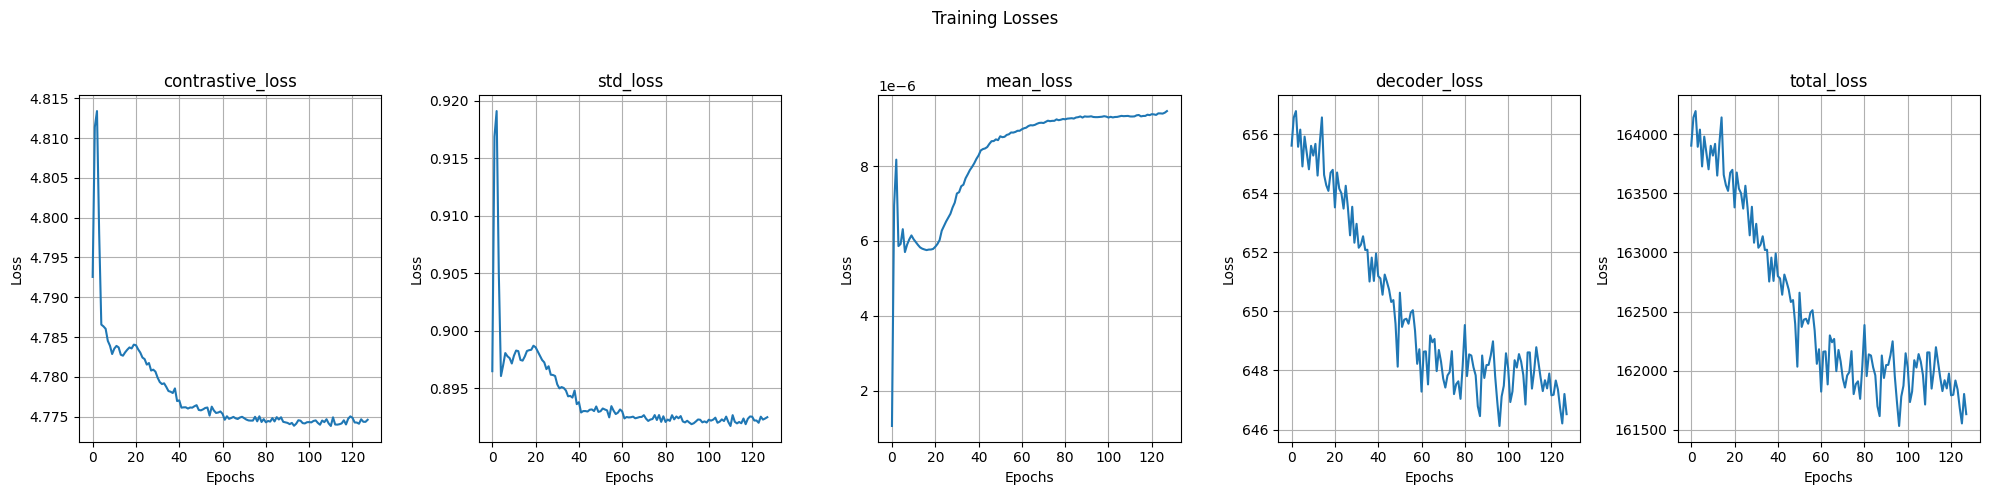

In [ ]:
import matplotlib.pyplot as plt


def plot_epoch_losses(epoch_losses_list, title="Training Losses", xlabel="Epochs", ylabel="Loss"):
    """
    Plots the losses for each epoch from a list of dictionaries.

    Parameters:
    - epoch_losses_list (list of dict): The list containing dictionaries of loss values for each epoch.
    - title (str): The title of the plot.
    - xlabel (str): The label for the x-axis.
    - ylabel (str): The label for the y-axis.
    """

    # Initialize dictionaries to hold losses by type
    losses_by_type = {
        'contrastive_loss': [],
        'std_loss': [],
        'mean_loss': [],
        'decoder_loss': [],
        'total_loss': []
    }

    # Extract losses for each epoch
    for epoch_losses in epoch_losses_list:
        for key in losses_by_type.keys():
            losses_by_type[key].append(epoch_losses[key])

    plt.figure(figsize=(20, 5))  # Adjust the width to accommodate more subplots

    # Plot each type of loss in its own subplot
    for idx, (key, losses) in enumerate(losses_by_type.items(), 1):
        plt.subplot(1, 5, idx)  # 1 row, 5 columns, current plot index
        plt.plot(losses, label=key)
        plt.title(key)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)

    plt.suptitle(title)  # Super title for all subplots
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
    plt.show()


plot_epoch_losses(epoch_losses_list)

0


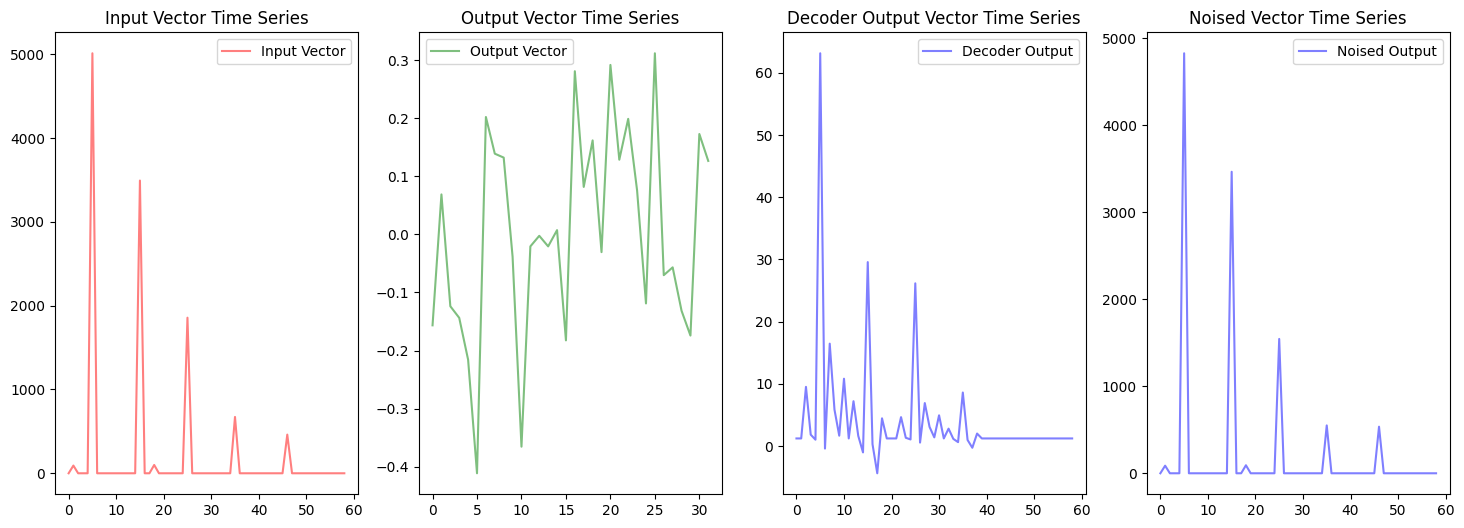

1


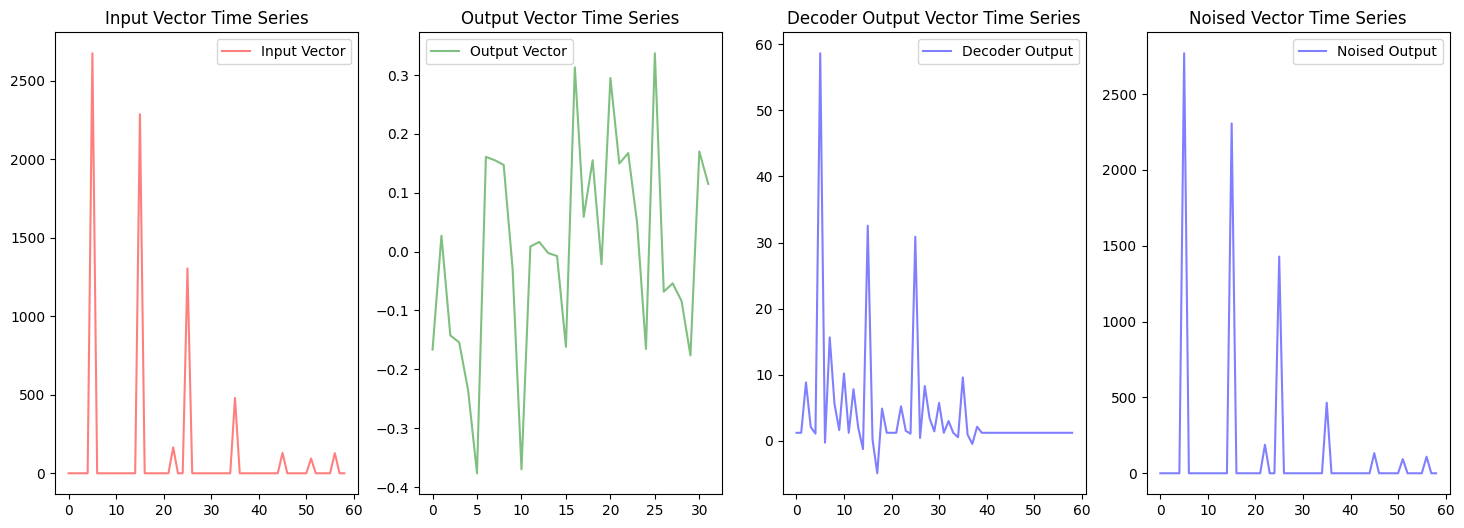

714


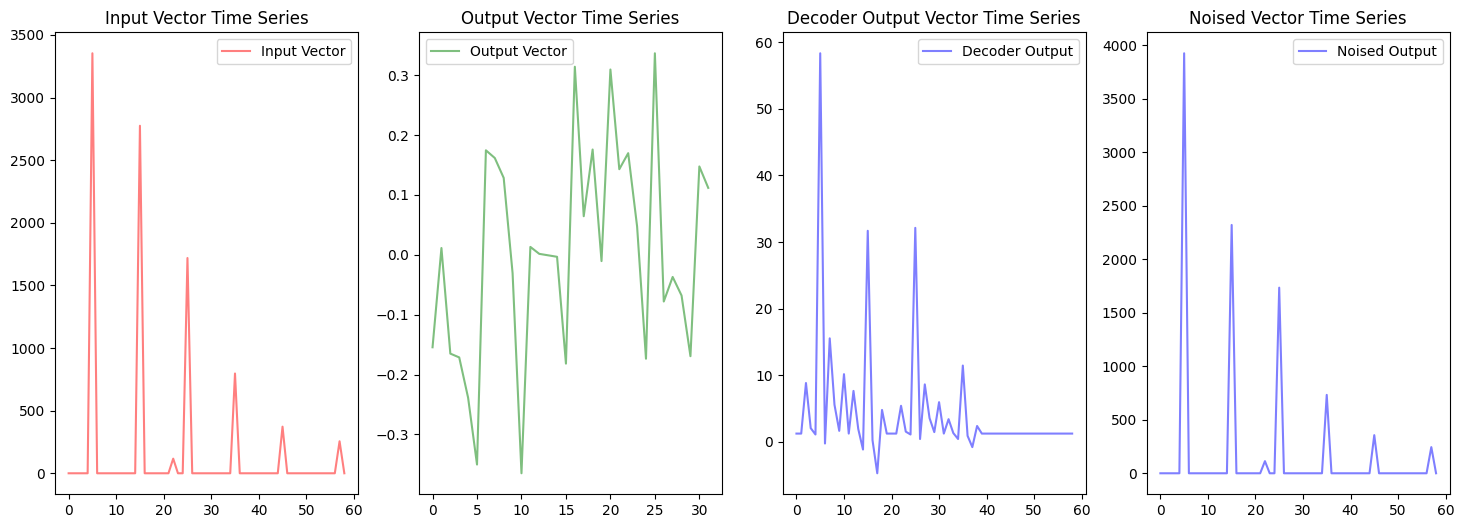

715


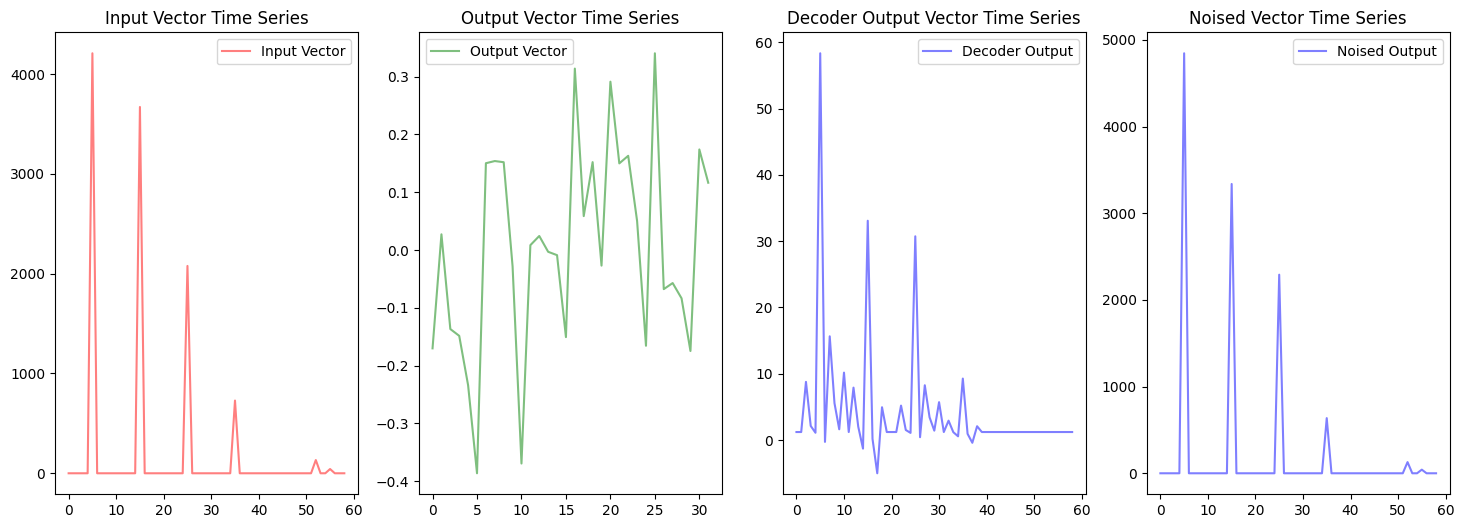

924


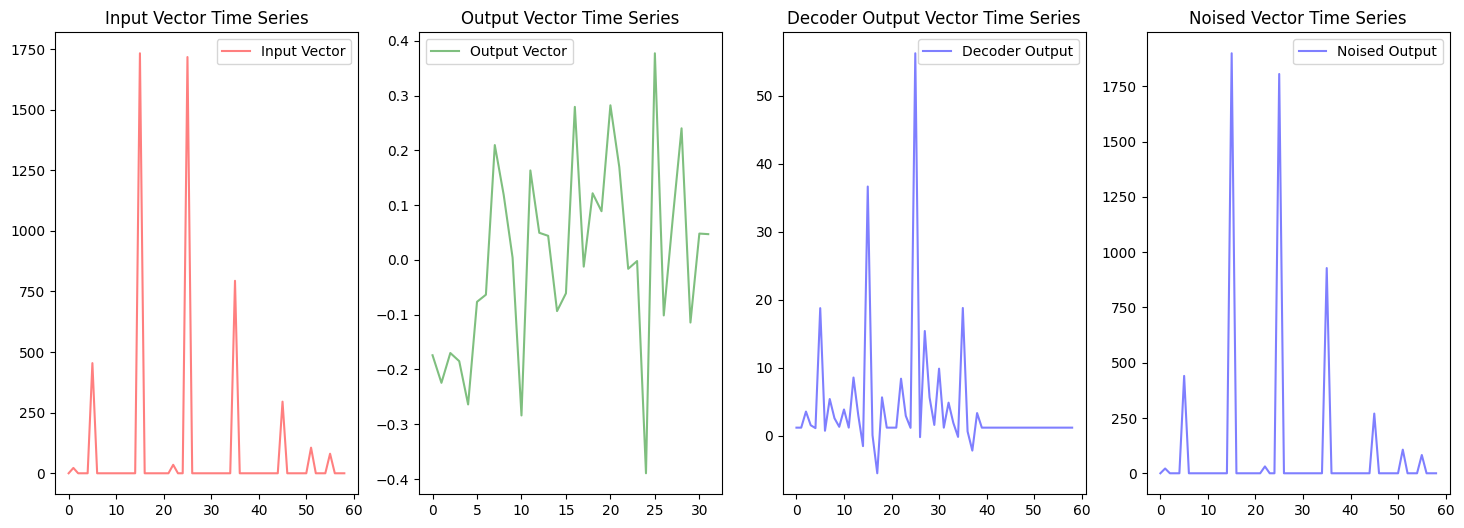

925


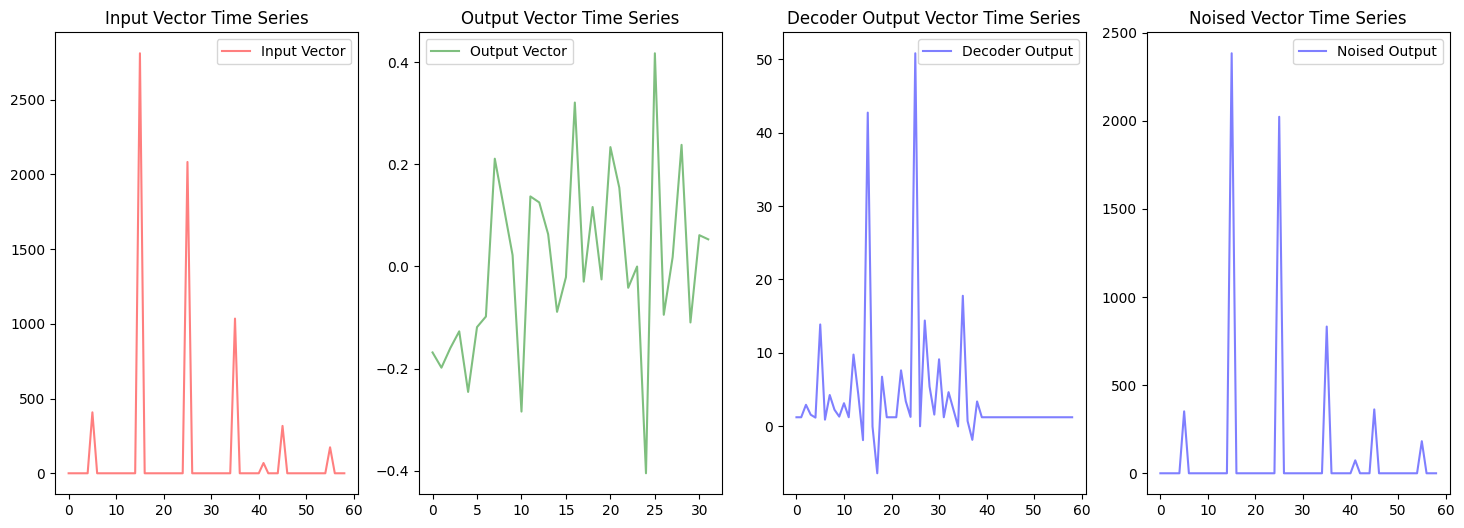

1598


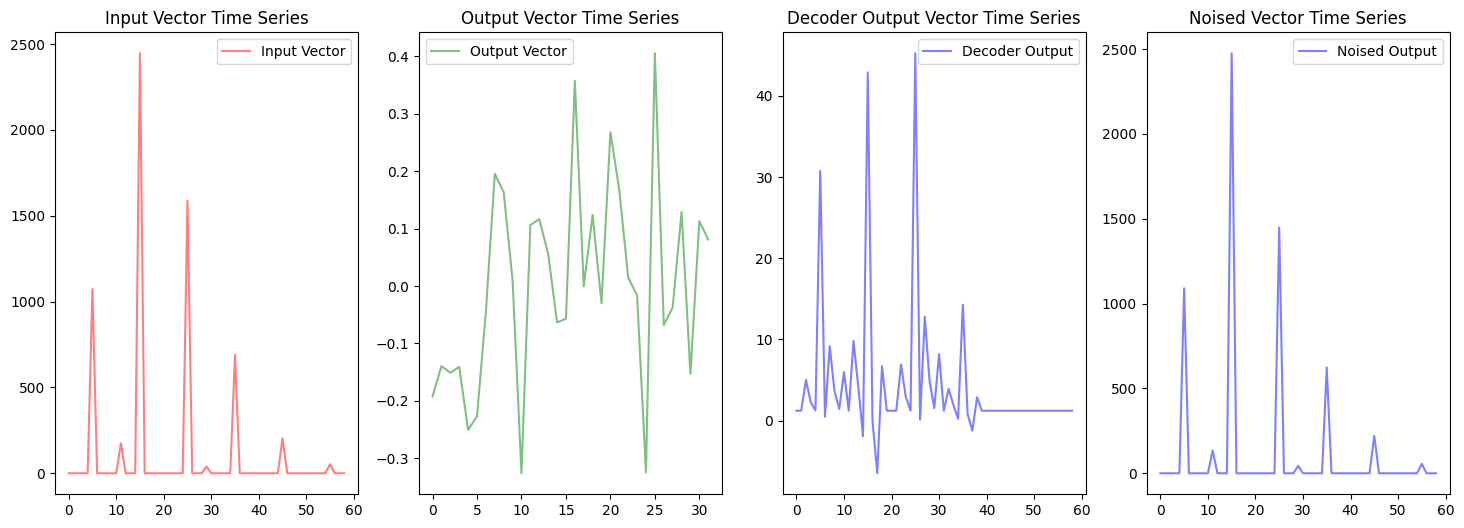

1599


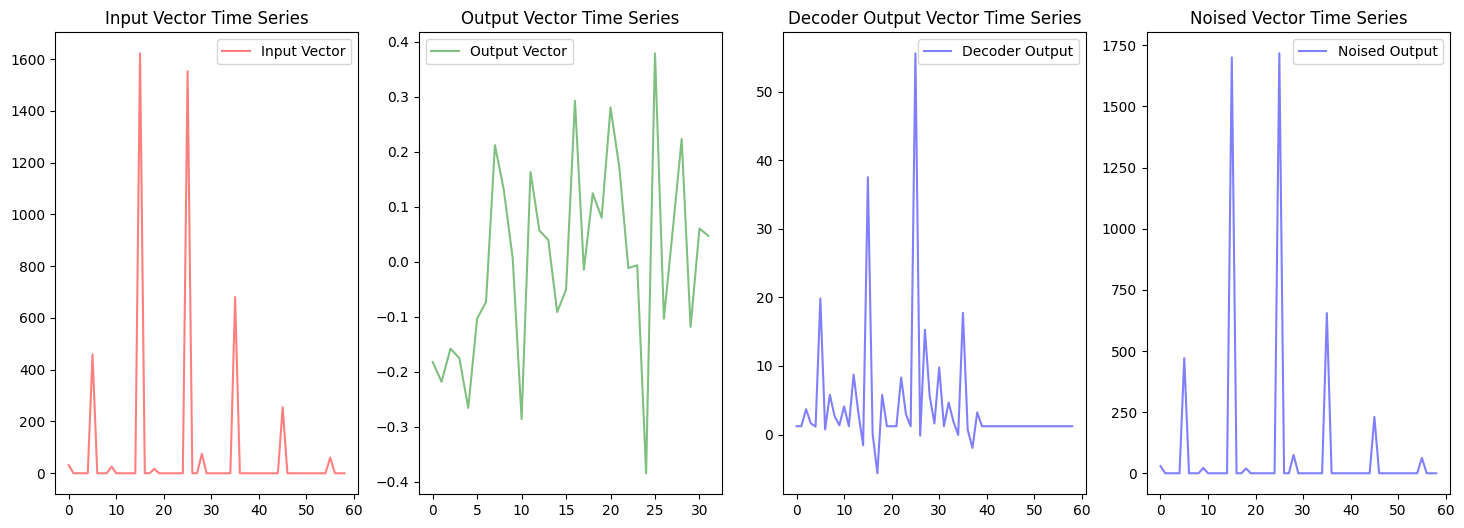

Output vectors saved to /content/drive/My Drive/MSI-Segmentation/results/sztuczne_dane_28-07-2024-22-19_conv_False/CLR_feat.npy


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def run_thru_NN(model, parquet_dir):
    dataloader = iter(create_dataloader(parquet_dir, batch_size=1, shuffle=False))
    model.eval()

    collected_output_vectors = []

    au = 0

    X = next(dataloader, None)
    while X is not None:
        X_tensor = torch.Tensor(X['features']).to(model.device)
        with torch.no_grad():
            output_batch, decoder_output_batch = model(X_tensor)

        input_vector = X_tensor.detach().cpu().numpy().squeeze()
        output_vector = output_batch.detach().cpu().numpy().squeeze()
        decoder_output = decoder_output_batch.detach().cpu().numpy().squeeze()

        collected_output_vectors.append(output_vector)
        au += 1
        if au in [1, 2, 715, 716, 925, 926, 1599, 1600]:
            print(X['pos'][0])
            plot_timeseries(input_vector, output_vector, decoder_output, noise(X_tensor).detach().cpu().numpy().squeeze())

        X = next(dataloader, None)


    # Convert collected output vectors to a numpy array and save
    collected_output_vectors = np.array(collected_output_vectors)
    output_file_path = os.path.join(output_folder, 'CLR_feat.npy')
    np.save(output_file_path, collected_output_vectors)
    print(f"Output vectors saved to {output_file_path}")


def plot_timeseries(input_vector, output_vector, decoder_output, noised):
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))

    # Plot input vector as time series
    axes[0].plot(input_vector, 'r-', alpha=0.5)
    axes[0].set_title('Input Vector Time Series')
    axes[0].legend(['Input Vector'])

    # Plot output vector as time series
    axes[1].plot(output_vector, 'g-', alpha=0.5)
    axes[1].set_title('Output Vector Time Series')
    axes[1].legend(['Output Vector'])

    # Plot decoder output vector as time series
    axes[2].plot(decoder_output, 'b-', alpha=0.5)
    axes[2].set_title('Decoder Output Vector Time Series')
    axes[2].legend(['Decoder Output'])

    # Plot noised input vector as time series
    axes[3].plot(noised, 'b-', alpha=0.5)
    axes[3].set_title('Noised Vector Time Series')
    axes[3].legend(['Noised Output'])

    plt.show()

run_thru_NN(model_CLR, parquet_dir)

In [ ]:
# Your code block here

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 134.11050057411194 seconds


In [ ]:
for key, value in model_CLR.state_dict().items():
    print(f"{key}: {value.shape}")

embedding.net.0.weight: torch.Size([2, 1, 7])
embedding.net.0.bias: torch.Size([2])
embedding.net.1.weight: torch.Size([27])
embedding.net.1.bias: torch.Size([27])
embedding.net.3.weight: torch.Size([4, 2, 3])
embedding.net.3.bias: torch.Size([4])
embedding.net.4.weight: torch.Size([13])
embedding.net.4.bias: torch.Size([13])
embedding.net.7.weight: torch.Size([32, 52])
embedding.net.7.bias: torch.Size([32])
embedding.net.8.weight: torch.Size([32])
embedding.net.8.bias: torch.Size([32])
embedding.decoder.0.weight: torch.Size([52, 32])
embedding.decoder.0.bias: torch.Size([52])
embedding.decoder.1.weight: torch.Size([52])
embedding.decoder.1.bias: torch.Size([52])
embedding.decoder.3.weight: torch.Size([4, 2, 3])
embedding.decoder.3.bias: torch.Size([2])
embedding.decoder.4.weight: torch.Size([27])
embedding.decoder.4.bias: torch.Size([27])
embedding.decoder.6.weight: torch.Size([2, 1, 7])
embedding.decoder.6.bias: torch.Size([1])


In [ ]:
if False:
    checkpoint_path = "/content/drive/My Drive/MSI-Segmentation/results/sztuczne_dane_08-11-2023-10-51_conv_True/model_CLR.ckpt"
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model_CLR.load_state_dict(checkpoint)  # Load the state dict

    run_thru_NN(model_CLR, parquet_dir)

In [ ]:
if False:
    checkpoint_path = "/content/drive/My Drive/MSI-Segmentation/results/sztuczne_dane_25-07-2024-20-25_conv_True/model_CLR.ckpt"
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model_CLR.load_state_dict(checkpoint)  # Load the state dict

    run_thru_NN(model_CLR, parquet_dir)